<a href="https://colab.research.google.com/github/terrysu64/Machine-Learning-and-Data-Science-Projects/blob/main/convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural networks + computer vision

In [1]:
#get data

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-26 19:00:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   103MB/s    in 1.0s    

2022-07-26 19:00:33 (103 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



### inspect data

In [2]:
!ls pizza_steak

test  train


In [3]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(dirpath, len(dirnames), len(filenames))

pizza_steak 2 0
pizza_steak/train 2 0
pizza_steak/train/pizza 0 750
pizza_steak/train/steak 0 750
pizza_steak/test 2 0
pizza_steak/test/pizza 0 250
pizza_steak/test/steak 0 250


In [4]:
#get classnames
import pathlib 
import numpy as np

data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['pizza', 'steak'], dtype='<U5')

(512, 512, 3)


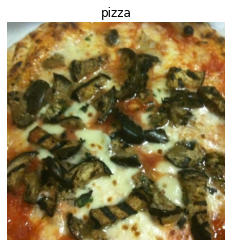

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import random

def view_rand_img(target_dir, target_class):
  folder = target_dir+target_class
  rand_img = random.sample(os.listdir(folder), 1)
  img = mpimg.imread(folder + "/" + rand_img[0])

  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(img.shape)

  return img

img=view_rand_img("pizza_steak/train/", "pizza")

In [6]:
img.shape 

(512, 512, 3)

## end-to-end example

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG #batches of tensor image data with real-time data augmentation.

tf.random.set_seed(42)

#preprocess data
train_datagen = IDG(rescale=1./224)
valid_datagen = IDG(rescale=1./224)

#paths
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

#import data and turn to batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data)
                    )

Epoch 1/5
47/47 [==============================] - 11s 215ms/step - loss: 0.6267 - accuracy: 0.6580 - val_loss: 0.4323 - val_accuracy: 0.8220
Epoch 2/5
47/47 [==============================] - 10s 210ms/step - loss: 0.4748 - accuracy: 0.7933 - val_loss: 0.4079 - val_accuracy: 0.8200
Epoch 3/5
47/47 [==============================] - 10s 205ms/step - loss: 0.4725 - accuracy: 0.7947 - val_loss: 0.3973 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 10s 207ms/step - loss: 0.4245 - accuracy: 0.8133 - val_loss: 0.4181 - val_accuracy: 0.8160
Epoch 5/5
47/47 [==============================] - 10s 205ms/step - loss: 0.3874 - accuracy: 0.8340 - val_loss: 0.3677 - val_accuracy: 0.8380


In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_23 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

## model debrief

In [34]:
img,labels = train_data.next()
len(img), len(labels)

(32, 32)